$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[1]{\mathbb{E}\left[#1\right]}
\newcommand{\given}[]{~\middle\vert~}
$$

# CS236605: Deep Learning
# Tutorial 7: Deep Reinforcement Learning

## Introduction

In this tutorial, we will cover:

TODO

In [3]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory Reminders: The RL setting

Reinforcement learning is a general framework of a learning setting which includes:
- An agent: something which interacts, or performs actions on an **environment** on our behalf,
  according to some deterministic or stochcastic policy.
- Actions: Things that the agent can do.
- An environment: Everything outside of the agent's control. The agent can (partially) observe it's state,
  and it periodically gets rewards from the environment.
- Observations: Things about the state of the environment which the agent can periodically observe.
- Reward: A scalar value which the agent receives from the environment after (some) actions.

<img src="img/rl_setting2.png" width="700"/>

**Example**: Stock market trading
- Agent: a trading system or algorithms which can buy and sell stocks, bonds, etc. 
- Actions: what to buy or sell, and how much.
- Environment: The entire market and everything that may potentially influence it (news events, politics, economic conditions, etc). Potentially everything in the universe.
- Observations: Stock prices, market indices, etc.
- Reward: Total accumulated profit.

So far we have seen two types of learning paradigms:
- Supervised, in which we learn a mapping based on labelled samples;
- Unsupervised, in which we learn the latent structure of our data.

Reinforcement learning is a different paradigm which doesn't cleanly map into either supervised or unsupervised.

- On one hand, there are no predefined labels.
- However, instead we have a **reward system**, which guides the learning process through.
- By observing rewards (which can be positive, negative or neutral) we expect our agent to learn what actions (and which states) lead to positive rewards.
- In essence, we **create our own labels** based on the experiences of the agent.

The RL setting presents some unique challenges.

- Non i.i.d observations
    - since they depend on the agent
    - we might only observe only non-useful information
- Exploration vs. exploitation trade-off
    - discovering new strategies may be at the cost of short term rewards loss
- Delayed reward: can even be one single reward at the end
    - need to discover causal relations between actions and rewards despite the delays

### Markov processes

A **Markov process** (MP; aka Markov chain), is a system with a finite number of **states**, and time-invariante **transition probabilities** between them.
- **Markov property**: transition probabilities to next state depend only on current state.
- At each time step $t$, the next state $S_{t+1}$ is sampled based on the current state $S_{t}$.
- Fully described by states $\cset{S}=\{s_i\}_{i=1}^{N}$ and transition matrix
  $$P_{i,j}=P(s_i,s_j)=\Pr(S_{t+1}=s_j|S_{t}=s_i).$$

A **Markov reward process** (MRP) is an MP where in addition we have,
- Immediate reward for transition from state $s_i$ to state $s_j$: $R_{i,j} = R(s_i,s_j)$.
- Discount factor $\gamma\in[0,1]$ for future rewards.

Total discounted reward (aka gain) from time $t$:
$$
G_t = R_{t+1}+\gamma R_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^k R_{t+1+k}.
$$

The **value** of a state $s$ it's it's expected future return:
$$
v(s) = \E{G_t|S_t = s}.
$$

A **Markov desicion process** (MDP) is an MRP where in addition,
- We have a finite set of **actions** that can be performed by our agent at each state: $\cset{A}=\{a_k\}_{k=1}^{K}$.

- The transition probabilities are now action-dependent:
   $$P_{i,j,k} = P_{a_k}(s_i,s_j) = \Pr(S_{t+1}=s_j|S_t=s_i,A_t=a_k).$$
   <img src="img/mdp_transition_prob.png" width="500"/>

- The immediate reward is now also action-dependent. We will also ignore the dependence on the next state:
$$
R_{t+1} = R(S_t,A_t).
$$

We define the **policy** of an agent as the conditional distribution,
$$
\pi(a|s) = \Pr(A_t=a\vert S_t=s).
$$
This defines the actions the agent is likely to take at state $s$. Assumed to be time invariant.

The **state-value function** of an MDP is now policy-dependent:

\begin{align}
v_{\pi}(s) &= \E{G_t|S_t = s,\pi} \\
&= \E{\sum_{t=0}^{\infty} \gamma^t R_{t+1}\given S_0=s, \pi} \\
&= \E{R_1 +\gamma v_\pi(S_1) \given S_0=s, \pi}.
\end{align}

Notice:
1. The state value is the *expected immediate return* plus the *expected discounted value of the next state*.
2. The expectation is over the selected action (under the policy distribution) and the next state due to this action.

Writing the expectation explicitly for the state-value function, we get:

$$
v_{\pi}(s) =
\sum_{a\in\cset{A}}\pi(a|s)R(s,a) +
\gamma \sum_{a\in\cset{A}} \sum_{s'\in\cset{S}} \pi(a|s) P_{a}(s,s') v_{\pi}(s').
$$

<img src="img/v_expectation.png" width="500" />


Example MDP with computed state values (not optimal)

<img src="img/mdp.png" width="700"/>


Value of the right study state:
$$
0.5\cdot(1+0.2\cdot -1.3 + 0.4 \cdot 2.7 + 0.4\cdot 7.4) + 0.5\cdot (10+0) = 7.4
$$

We also define an **action-value function** which is the expected return of a an agent starting at state $s$ and performing action $a$:

\begin{align}
q_{\pi}(s,a) &= \E{G_t|S_t = s,A_t=a,\pi} \\
&= \E{\sum_{t=0}^{\infty} \gamma^t R_{t+1}\given S_0=s, A_0=a, \pi} \\
&= \E{R_1 + \gamma q_{\pi}(S_1,A_1) \given S_0=s, A_0=a, \pi}.
\end{align}

Similarly to before, we can write the expectation explicitly for the action-value function:

$$
q_{\pi}(s,a) =
R(s,a) +
\gamma \sum_{s'\in\cset{S}} P_{a}(s,s') \sum_{a'\in\cset{A}} \pi(a'|s') q_{\pi}(s',a').
$$

<img src="img/q_expectation.png" width="500" />


Notice that if instead of taking the expectation over actions we take the action with the maximal value,
we'll get a better action-value for our current state.

Therefore, any **optimal** action-value function $q^\ast$ must satisfy

$$
q^\ast(s,a) =
R(s,a) +
\gamma \sum_{s'\in\cset{S}} P_{a}(s,s') \max_{a'\in\cset{A}} q^\ast(s',a'),
$$
which is known as the **Bellman optimiality equation**.

- For any MDP, there is always at least one **deterministic optimal policy**.
- If we somehow know the optimal action value function, $q^\ast(s,a)$, we can get an optimal policy:

$$
\pi^\ast(a|s) =
\begin{cases}
1, & a = \arg\max_{a'\in\cset{A}} q^\ast(s,a') \\
0, & \text{else}
\end{cases}
$$

One RL approach, **$q$-learning**, is thus to approximate $q^\ast(s,a)$ from observations.

## OpenAI Gym

From their [site](https://gym.openai.com),

    Gym is a toolkit for developing and comparing reinforcement learning algorithms. 
    It supports teaching agents everything from walking to playing games
    like Pong or Pinball.

In RL terms, `gym` will provide us an **environment** which comes with states,
possible actions and rewards.
We will implement our **agent** to work with these environments.

We'll see a quick example and then explain what's going on and how to use `gym`.

Let's play the classic SpaceInvaders Atari game, using a randomly-playing agent.

<img src="img/Space_Invaders_flyer_1978.jpg" />


In [7]:
import gym
from gym.wrappers import Monitor

# Create a new SpaceInvaders environment
# Wrap it in a Monitor so that we record video
with Monitor(gym.make('SpaceInvaders-v0'), "out", force=True) as env:
    
    # Reset the env to start a new episode
    env.reset()
    episode_done = False
    total_reward = 0
    total_steps = 0
    
    # This is our agent code. It will just play randomly.
    # As long as the episode is not done (not Game Over), we:
    while not episode_done:
        # 1. Choose a random valid action to do
        action = env.action_space.sample()
        
        # 2. Do the random action and get feedback from the environment
        obs, reward, episode_done, extra_info = env.step(action)
        
        total_reward += reward
        total_steps += 1

print(f'Played {total_steps} steps. Total reward: {total_reward}')

Played 511 steps. Total reward: 110.0


How do we see what happened?

We have a video recording of the last episode generated by our `Monitor`.

In [9]:
import IPython.display

# A helper function that shows the last video from a Monitor env wrapper
def show_last_video(monitor_env, width='auto', height='auto'):
    video_path = monitor_env.videos[-1][0]
    video_path = os.path.relpath(video_path, start=os.path.curdir)
    
    raw_html = f'<video src="{video_path}" controls autoplay width="{width}" height="{height}" />'
    return IPython.display.HTML(data=raw_html)

In [10]:
print('Our random agent in action:')
show_last_video(env, width=400)

Our random agent in action:


`gym` offeres many other available environments:  
 <https://gym.openai.com/envs>

### Anatomy of an `Environment`

Let's dig in a bit deeper to see what we're working with when using `gym`'s `Environment`s.

Usually, the `Environment` you use is actually multiple environments, each wrapping another.

In [12]:
env = gym.make('SpaceInvaders-v0')
env?

Type:            TimeLimit
String form:     <TimeLimit<AtariEnv<SpaceInvaders-v0>>>
File:            ~/anaconda3/envs/cs236605-tutorials/lib/python3.7/site-packages/gym/wrappers/time_limit.py
Docstring:       <no docstring>
Class docstring:
The main OpenAI Gym class. It encapsulates an environment with
arbitrary behind-the-scenes dynamics. An environment can be
partially or fully observed.

The main API methods that users of this class need to know are:

    step
    reset
    render
    close
    seed

And set the following attributes:

    action_space: The Space object corresponding to valid actions
    observation_space: The Space object corresponding to valid observations
    reward_range: A tuple corresponding to the min and max possible rewards

Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.

The methods are accessed publicly as "step", "reset", etc.. The
non-underscored versions are wrapper methods to which we may add
functi

#### Observations

In [13]:
# Starts a new episode, returning an initial observation
obs = env.reset()

What are we observing exactly?

In [14]:
print(type(obs))
obs.shape

<class 'numpy.ndarray'>


(210, 160, 3)

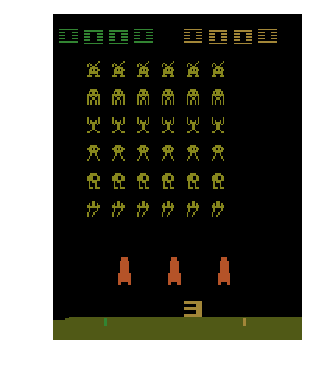

In [15]:
def show_observation(obs, size=6):
    f, ax = plt.subplots(1,1,figsize=(size,size))
    ax.imshow(obs)
    ax.axis('off')

show_observation(obs)

What is space of possible observations?

In [16]:
env.observation_space

Box(210, 160, 3)

`Box` is a `Space` which represents an n-dimentinoal Tensor with values in range [low, high].

In [17]:
(env.observation_space.low.reshape(-1)[0],
env.observation_space.high.reshape(-1)[0])

(0, 255)

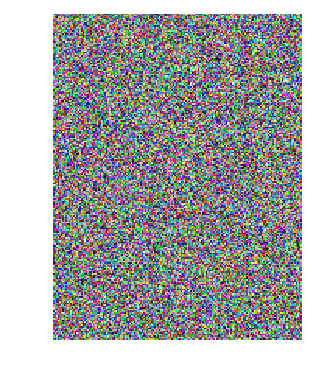

In [18]:
obs_sample = env.observation_space.sample()

show_observation(obs_sample)

#### Actions

What **actions** can we perform in this environment?

In [19]:
env.action_space

Discrete(6)

`Discrete` is a `Space` which represents `n` integers with values `0,1,...,n-1`.

In this case, this means we have 6 possible actions we can choose from at each step of our game.

In [20]:
print(env.action_space.contains(0))
print(env.action_space.contains(6))

True
False


But what do they mean? It's game specific. For the Atari environments:

In [21]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

How do we perform **actions** on the environment?

reward=0.0, done=False, exrta_info={'ale.lives': 0}


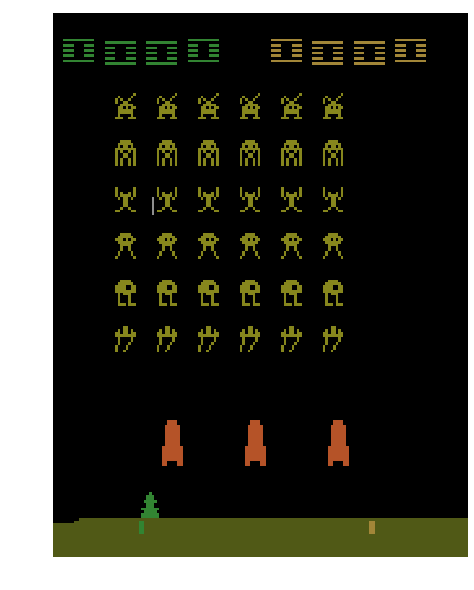

In [23]:
env.reset()

fire_action = 1

# Run for a few (simulated) seconds
fps = 30
seconds = 2
for _ in range(fps*seconds):
    obs, reward, episode_done, exrta_info = env.step(fire_action)

show_observation(obs, size=10)
print(f'reward={reward}, done={episode_done}, exrta_info={extra_info}')

In [24]:
# When done, need to close() the environment
env.close()

#### Wrappers

`Wrapper`s allow you to **wrap** an `Environment` instance and modify it's behavior.

We have already used the `Monitor` wrapper, which writes the observation as a video frame each step, and also outputs data about the agents progress during the episode.

There are some pre-defined wrapper types which allow you to easily intervene in the interaction between your agent and the environment:
- `ObservationWrapper` allows you to modify the **observations** before they get to the agent.
- `RewardWrapper` allows you to modify the **reward** before it gets to the agent.
- `ActionWrapper` allows you to modify the agent's action before it gets to the environment.

In [25]:
class MalfunctioningScreenWrapper(gym.ObservationWrapper):
    # Override the observation() method from ObservationWrapper to change the observation
    # on the way to the agent
    def observation(self, obs: np.ndarray):
        r = np.random.randint(10)
        # Invert colors and with a low probability set a single channel
        obs  = 255 - obs
        if r < 3:
            obs[:,:,r] = 128
            
        self.last_obs = obs
        return obs
    
    # Change render() to show modified observations in video
    def render(self, mode, **kw):
        if mode == 'rgb_array':
            return self.last_obs

In [26]:
class TriggerHappyActionWrapper(gym.ActionWrapper):
    # Override the action() method from ActionWrapper to change the action
    # on the way to the environment
    def action(self, act):
        # With a high probability, just do the FIRE action
        if np.random.random() < 0.9:
            return 1
        else:
            return act

Lets see our `Wrapper`s in action:

In [27]:
env = \
MalfunctioningScreenWrapper(
    TriggerHappyActionWrapper(
        gym.make('SpaceInvaders-v0')
    )
)
with Monitor(env, 'out', force=True) as env:
    env.reset()
    episode_done = False
    total_reward = 0
    total_steps = 0
    while not episode_done:
        action = env.action_space.sample()
        obs, reward, episode_done, extra_info = env.step(action)
        total_reward += reward
        total_steps += 1

print(f'Played {total_steps} steps. Total reward: {total_reward}')

Played 841 steps. Total reward: 410.0


In [28]:
show_last_video(env, width=400)

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- David Silver's RL course, www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
- Max Lapan, Deep Reinforcement Learning Hands-On, Packt, 2018.

In [ ]:
f, ax = plt.subplots()

In [ ]:
img = ax.imshow([[1,2],[3,4]])

In [ ]:
ax.imshow?

In [ ]:
info

In [ ]:
# import time
# from IPython import display

# def render_gym_env(env, img=None):
#     if img is None:
#         _, ax = plt.subplots(figsize=(9,9))
#         ax.axis('off')
#         img = ax.imshow(env.render(mode='rgb_array'))  
#         return img
#     img.set_data(env.render(mode='rgb_array'))
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     plt.close()
#     time.sleep(0.01)